# Image Captioning using RNN 



### Motivation 

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Load the feature map provided to you
features_map = torch.load('/Users/sathyasris/Downloads/resnet50_caption.pt', map_location=device)



##### 5.1 Design a RNN-based decoder 


In [4]:
import json
import pandas as pd

with open('/Users/sathyasris/Downloads/COMP5625M_data_assessment_2/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [5]:
coco_subset = pd.read_csv("/Users/sathyasris/Downloads/COMP5625M_data_assessment_2/coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

,image_id,id,caption,file_name
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
16758,9,663627,there are containers filled with different kin...,000000000009.jpg
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg


In [6]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
16758,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [7]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:3547, validation:506, test:1015


In [8]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [9]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [10]:
### build vocabulariy for each set - train, val and test 
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2348


In [11]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

2513

In [12]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

/Applications/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [14]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [15]:
# say this is as below 
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        # your code
        self.resize=nn.Linear(2048,embed_size)
        # batch normalisation helps to speed up training
        # your code
        self.bn=nn.BatchNorm1d(embed_size, momentum=0.01)

        # your code for embedding layer
        self.embed=nn.Embedding(vocab_size,embed_size)

        # your code for RNN
        self.rnn=nn.LSTM(embed_size,hidden_size,num_layers,batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code
        embeddings=torch.cat((im_features.unsqueeze(1),embeddings),1)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed=nn.utils.rnn.pack_padded_sequence(embeddings,lengths,batch_first=True)
        hiddens,_=self.rnn(packed)

        outputs = self.linear(hiddens[0]) #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [17]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features 

In [18]:
# loss and optimizer here
# your code here --->
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(decoder.parameters(), lr=0.001)


# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->
        features_=features_.to(device)
        captions_=captions_.to(device)
        lengths_=[l-1 for l in lengths_]
        outputs=decoder(features_, captions_, lengths_)
        targets=pack_padded_sequence(captions_,lengths_,batch_first=True).data
        loss=criterion(outputs,targets)
        decoder.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")
    
    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():  
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->
            features_=features_.to(device)
            captions_=captions_.to(device)
            lengths_=[l-1 for l in lengths_]
            outputs=decoder(features_, captions_, lengths_)
            targets=pack_padded_sequence(captions_,lengths_,batch_first=True).data
            loss=criterion(outputs,targets)
            
            total_loss+=loss.item()

            
    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

(5, 2)
Epoch [1/5], Step [0/555], Loss: 7.8333
Epoch [1/5], Step [10/555], Loss: 6.2737
Epoch [1/5], Step [20/555], Loss: 5.6735
Epoch [1/5], Step [30/555], Loss: 5.5607
Epoch [1/5], Step [40/555], Loss: 5.0737
Epoch [1/5], Step [50/555], Loss: 5.2847
Epoch [1/5], Step [60/555], Loss: 4.7769
Epoch [1/5], Step [70/555], Loss: 4.9171
Epoch [1/5], Step [80/555], Loss: 4.8648
Epoch [1/5], Step [90/555], Loss: 4.6424
Epoch [1/5], Step [100/555], Loss: 4.4577
Epoch [1/5], Step [110/555], Loss: 4.6231
Epoch [1/5], Step [120/555], Loss: 4.3607
Epoch [1/5], Step [130/555], Loss: 4.3754
Epoch [1/5], Step [140/555], Loss: 4.3272
Epoch [1/5], Step [150/555], Loss: 4.4340
Epoch [1/5], Step [160/555], Loss: 4.0519
Epoch [1/5], Step [170/555], Loss: 4.1635
Epoch [1/5], Step [180/555], Loss: 4.0551
Epoch [1/5], Step [190/555], Loss: 3.8547
Epoch [1/5], Step [200/555], Loss: 4.0892
Epoch [1/5], Step [210/555], Loss: 3.6377
Epoch [1/5], Step [220/555], Loss: 3.7450
Epoch [1/5], Step [230/555], Loss: 3.9

Epoch [4/5], Step [200/555], Loss: 2.3715
Epoch [4/5], Step [210/555], Loss: 2.5748
Epoch [4/5], Step [220/555], Loss: 2.3597
Epoch [4/5], Step [230/555], Loss: 2.3595
Epoch [4/5], Step [240/555], Loss: 2.3587
Epoch [4/5], Step [250/555], Loss: 2.6603
Epoch [4/5], Step [260/555], Loss: 2.2565
Epoch [4/5], Step [270/555], Loss: 2.5256
Epoch [4/5], Step [280/555], Loss: 2.4322
Epoch [4/5], Step [290/555], Loss: 2.1841
Epoch [4/5], Step [300/555], Loss: 2.4678
Epoch [4/5], Step [310/555], Loss: 2.4599
Epoch [4/5], Step [320/555], Loss: 2.3465
Epoch [4/5], Step [330/555], Loss: 2.2937
Epoch [4/5], Step [340/555], Loss: 2.4871
Epoch [4/5], Step [350/555], Loss: 2.5381
Epoch [4/5], Step [360/555], Loss: 2.5402
Epoch [4/5], Step [370/555], Loss: 2.4879
Epoch [4/5], Step [380/555], Loss: 2.4143
Epoch [4/5], Step [390/555], Loss: 2.4741
Epoch [4/5], Step [400/555], Loss: 2.3318
Epoch [4/5], Step [410/555], Loss: 2.1599
Epoch [4/5], Step [420/555], Loss: 2.5511
Epoch [4/5], Step [430/555], Loss:

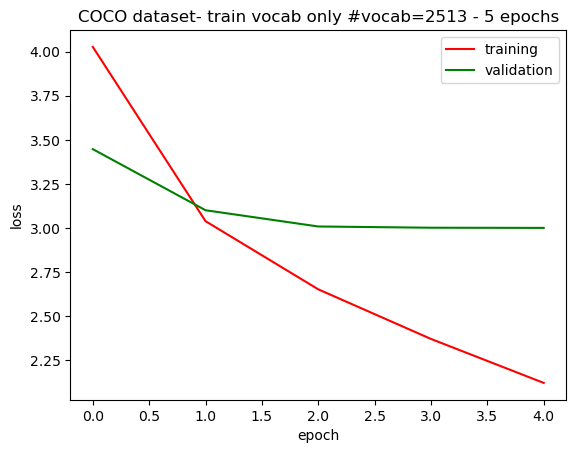

In [19]:
fig = plt.figure()
plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [20]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

#### Generate predictions on test data 

In [21]:
test_set.head(2)

,image_id,id,caption,file_name,clean_caption
1098,64,467168,a black and silver clock tower at an intersect...,000000000064.jpg,a black and silver clock tower at an intersect...
1097,64,480152,A very pretty clock on the side of a road.,000000000064.jpg,a very pretty clock on the side of a road


In [22]:
class COCOImagesDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.image_dir = "/Users/sathyasris/Downloads/COMP5625M_data_assessment_2/coco/images"
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name=os.path.join(self.image_dir, self.dataframe.iloc[idx]['file_name'])
        image=Image.open(img_name).convert("RGB")
        

        if self.transform:
            image = self.transform(image)
        filename=self.dataframe.iloc[idx]['file_name']
        return image, filename

In [23]:
data_transform = transforms.Compose([ 
    transforms.Resize(224),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    dataframe=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [24]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2513, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2513, bias=True)
)

In [25]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

GENERATED: 
a clock tower with a clock on it is shown in the distance of a building with a <unk> on it and a building with a <unk> roof with a <unk> roof in the background on the side of a building with a <unk> roof with a
REFERENCES: 
['a black and silver clock tower at an intersection near a tree'
 'a very pretty clock on the side of a road'
 'a clock is seen in front of a tall tree'
 'a pole with a clock that reads by a white car'
 'a clock sits on top of a black pole near a tree on a sidewalk near a crosswalk']



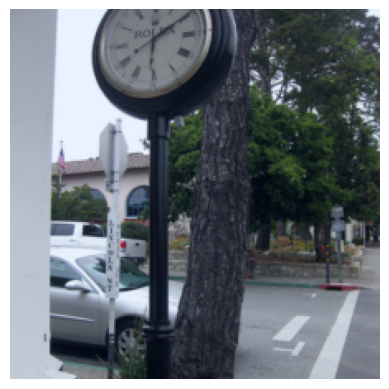

GENERATED: 
a group of people riding bikes down the street in the city with buildings on the side of the road and cars are driving down the street in the city with buildings on the side of the road beside a building with a <unk> on the side
REFERENCES: 
['there is a small bus with several people standing next to it'
 'people standing besides a bus taking to each other'
 'several people walking on a sidewalk near a large arch with figures on it'
 'people eating from food trucks near a commemorative archway'
 'a very big pretty arch way with a bunch of people near it']



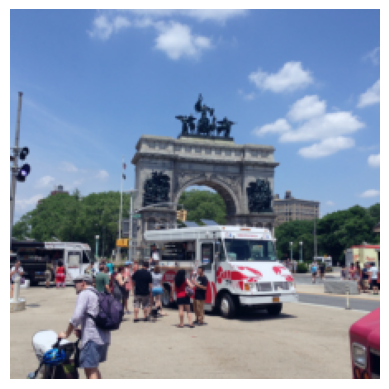

GENERATED: 
a close up of a bowl of broccoli and <unk> in a bowl with a <unk> on it and a table in a room with a bowl of <unk> <unk> it and a <unk> plant with <unk> <unk> in it on a wall in a room with
REFERENCES: 
['vegetables are growing in a garden box outside'
 'this is an image of a head of broccoli in a garden'
 'a nice head of broccoli grows on the plant in the corner of a garden'
 'a small garden filled with broccoli growing in a dirt patch'
 'a rock sits on top of a plant']



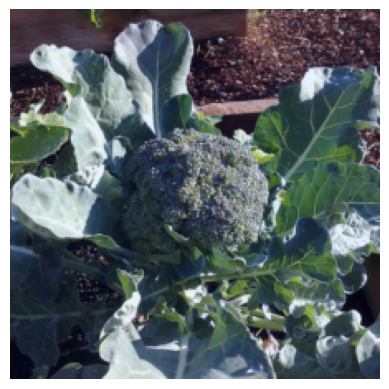

GENERATED: 
a man is standing on a sidewalk with <unk> in the background on it and a <unk> with a tree in the background on it is holding a <unk> board in the background with a <unk> in the background on it is in the background with a
REFERENCES: 
['a brown and black dog is laying on a roof'
 'a large dog sitting on top of a roof'
 'a dog is on the roof of a building'
 'a dog sitting on the roof of a building next to a satellite dish and a surfboard'
 'a dog is laying on the eaves of a house with clay pot roofing']



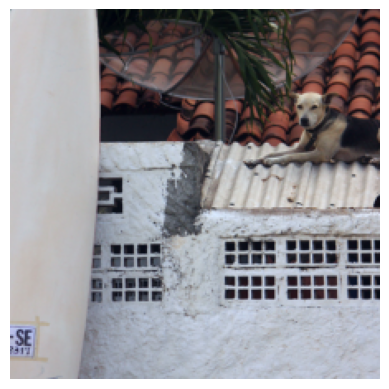

In [26]:
from PIL import Image
IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image, filename) in enumerate(test_loader):
        
        # your code here --->
        image = image.to(device)
        features = model(image)
        sampled_ids = decoder.sample(features)
        sampled_ids = sampled_ids.numpy()
        captions = decode_caption(sampled_ids[0], vocab)
        ref_captions = test_set.loc[test_set['file_name'] == filename[0]]['clean_caption'].values
        print(f"GENERATED: \n{captions}")
        print(f"REFERENCES: \n{ref_captions}")

        print("===================================\n")

        # Display the image
        timshow(image[0].cpu())
        idx += 1
        if idx == IMAGES_TO_SHOW:
            break


#### Caption evaluation using cosine similarity 

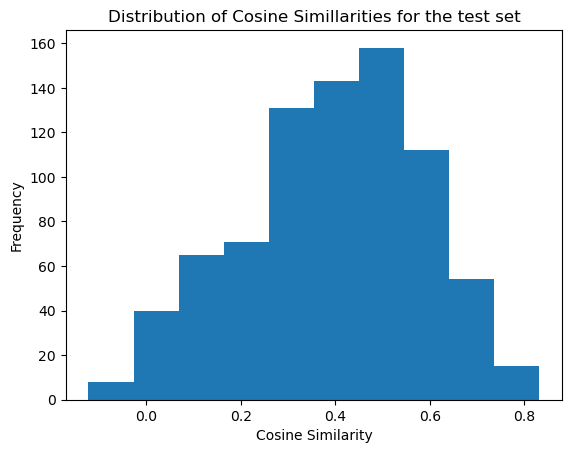

Average Cosine Similarity is: 0.3938418


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def get_word_embeddings(caption):
    words = caption.split()
    word_indices = []
    for word in words:
        if word in vocab.word2idx:
            word_indices.append(vocab.word2idx[word])
    word_embeddings=[]
    for word_index in word_indices:
        word_index_tensor=torch.tensor([word_index]).to(device)
        embedding=decoder.embed(word_index_tensor).detach().cpu().numpy().squeeze()
        word_embeddings.append(embedding)
    return word_embeddings

def avg_vec(caption):
    vectors=get_word_embeddings(caption)
    return np.mean(vectors, axis=0)

def cosine_sim(caption1,caption2):
    vector1=avg_vec(caption1)
    vector2=avg_vec(caption2)
    return cosine_similarity([vector1],[vector2])[0][0]

similarities=[]

with torch.no_grad():
    for i,(image, filename) in enumerate(test_loader):
        image=image.to(device)
        features=model(image)
        sampled_ids=decoder.sample(features)
        sampled_ids=sampled_ids.cpu().numpy()
        gen_captions=decode_caption(sampled_ids[0],vocab)
        ref_captions=test_set.loc[test_set['file_name']==filename[0]]['clean_caption'].values
        
        for ref_caption in ref_captions:
            similarity = cosine_sim(gen_captions, ref_caption)
            similarities.append(similarity)

avg_similarity=np.mean(similarities)

plt.hist(similarities, bins=10)
plt.title("Distribution of Cosine Simillarities for the test set")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

print("Average Cosine Similarity is:",avg_similarity)